# Import libraries

In [0]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import itertools

%matplotlib inline

Using TensorFlow backend.


In [0]:
#Path to train, valid and test directories.
train_path = 'augmented_data/train'
valid_path = 'augmented_data/valid'
test_path = 'augmented_data/test'

In [0]:
#Create batches of training, validation and testing dataset.
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224, 224), classes=['yes', 'no'], batch_size=32) 
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224, 224), classes=['yes', 'no'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224, 224), classes=['yes', 'no'], batch_size=200)


Found 1280 images belonging to 2 classes.
Found 440 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [0]:
#Obtaining images batch by batch. 
imgs, labels = next(train_batches)

In [0]:
#Function to plot the images with labels.
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


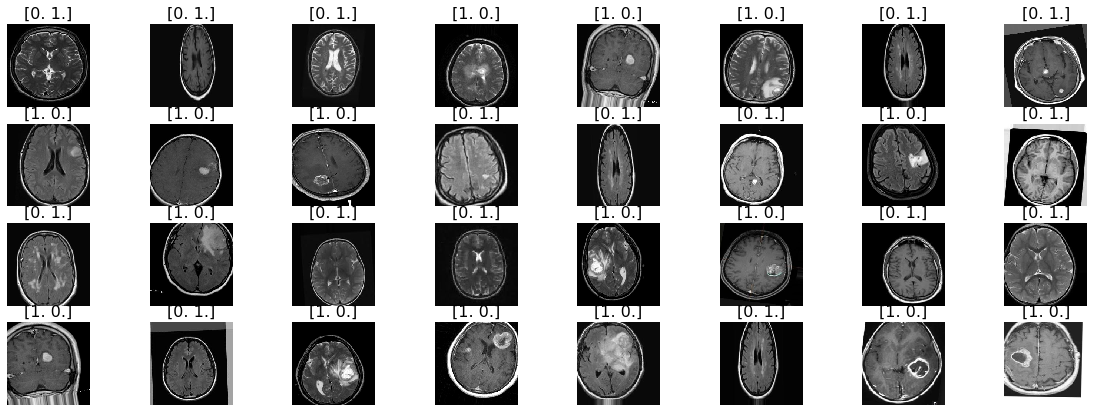

In [0]:
#Plot the first batch of train dataset.
plots(imgs, figsize=(20, 7), rows=4, titles=labels)

# Build and fine-tuned VGG16 model

In [0]:
#Import the VGG16 model.
vgg16_model = keras.applications.vgg16.VGG16()

In [0]:
#Popping the last Dense layer 
vgg16_model.layers.pop()

In [0]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
#Transform the model to Sequential model.
model = Sequential()

#Iterate through all the layers in VGG16 model.
for layer in vgg16_model.layers:
  #Add each layers to the Sequential model.
  model.add(layer)

In [0]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)     

In [0]:
#Freeze the weights of the layer.
for layer in model.layers:
  layer.trainable = False

In [0]:
#Add last Dense layer to the model that classify the images  as benign or malignant.
model.add(Dense(2, activation='softmax'))

In [0]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)     

# Train the model.

In [0]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.fit_generator(train_batches, steps_per_epoch=40, validation_data=valid_batches, validation_steps=40, epochs=5, verbose=2)

Epoch 1/5
 - 11s - loss: 0.1385 - acc: 0.9656 - val_loss: 0.4823 - val_acc: 0.8225
Epoch 2/5
 - 9s - loss: 0.1161 - acc: 0.9719 - val_loss: 0.4616 - val_acc: 0.8300
Epoch 3/5
 - 9s - loss: 0.1018 - acc: 0.9820 - val_loss: 0.4628 - val_acc: 0.8325
Epoch 4/5
 - 10s - loss: 0.0883 - acc: 0.9898 - val_loss: 0.4357 - val_acc: 0.8475
Epoch 5/5
 - 9s - loss: 0.0791 - acc: 0.9875 - val_loss: 0.5233 - val_acc: 0.8225


In [0]:
model.fit_generator(train_batches, steps_per_epoch=4, validation_data=valid_batches, validation_steps=4, epochs=20, verbose=2)

Epoch 1/20
 - 1s - loss: 0.0756 - acc: 0.9922 - val_loss: 0.6084 - val_acc: 0.8250
Epoch 2/20
 - 1s - loss: 0.0444 - acc: 1.0000 - val_loss: 0.4542 - val_acc: 0.8750
Epoch 3/20
 - 1s - loss: 0.0892 - acc: 0.9922 - val_loss: 0.4499 - val_acc: 0.7750
Epoch 4/20
 - 1s - loss: 0.0662 - acc: 1.0000 - val_loss: 0.4574 - val_acc: 0.8250
Epoch 5/20
 - 1s - loss: 0.0739 - acc: 0.9922 - val_loss: 0.3965 - val_acc: 0.8750
Epoch 6/20
 - 1s - loss: 0.0806 - acc: 0.9844 - val_loss: 0.6431 - val_acc: 0.8000
Epoch 7/20
 - 1s - loss: 0.0822 - acc: 0.9766 - val_loss: 0.4457 - val_acc: 0.9000
Epoch 8/20
 - 1s - loss: 0.0544 - acc: 1.0000 - val_loss: 0.2938 - val_acc: 0.8500
Epoch 9/20
 - 1s - loss: 0.0731 - acc: 0.9844 - val_loss: 0.5704 - val_acc: 0.8250
Epoch 10/20
 - 1s - loss: 0.0716 - acc: 0.9922 - val_loss: 0.3264 - val_acc: 0.8750
Epoch 11/20
 - 1s - loss: 0.0635 - acc: 1.0000 - val_loss: 0.4962 - val_acc: 0.7750
Epoch 12/20
 - 1s - loss: 0.0709 - acc: 0.9922 - val_loss: 0.5266 - val_acc: 0.7500
E

In [0]:
model.fit_generator(train_batches, steps_per_epoch=4, validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
 - 1s - loss: 0.0577 - acc: 1.0000 - val_loss: 0.5406 - val_acc: 0.7000
Epoch 2/5
 - 1s - loss: 0.0489 - acc: 1.0000 - val_loss: 0.3568 - val_acc: 0.9000
Epoch 3/5
 - 1s - loss: 0.0548 - acc: 1.0000 - val_loss: 0.4463 - val_acc: 0.8500
Epoch 4/5
 - 1s - loss: 0.0642 - acc: 1.0000 - val_loss: 0.3884 - val_acc: 0.8250
Epoch 5/5
 - 1s - loss: 0.0594 - acc: 1.0000 - val_loss: 0.7217 - val_acc: 0.7250


# Predict using VGG16 model.

In [0]:
test_imgs, test_labels = next(test_batches)

In [0]:
#Setting the test labels equal to the 0th index.
test_labels = test_labels[:,0]
test_labels

array([1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.], dtype=float32)

In [0]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [0]:
predictions.round()[:,0]

array([1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
       0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
       1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.], dtype=float32)

# Confusion Matrix

In [0]:
cm = confusion_matrix(test_labels, predictions.round()[:,0])

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis-1)[:, np.newaxis]
        print("Normalized Confusion Mtrix")
    else:
        print('Confusion Matrix, without normalization')
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i,j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[94  6]
 [14 86]]


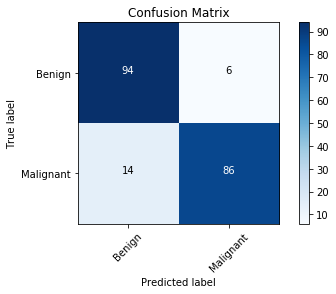

In [0]:
cm_plot_labels = ['Benign', 'Malignant']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

# Plot accuracy and loss graph.

In [0]:
history = model.history.history

In [0]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

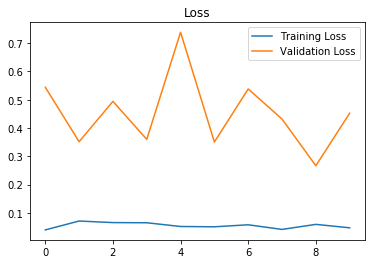

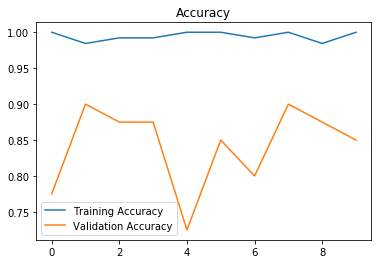

In [0]:
plot_metrics(history)

# Performance Measure.

In [0]:
accuracy_score(test_labels, predictions.round()[:,0])

0.9

In [0]:
f1_score(test_labels, predictions.round()[:,0])

0.9387755102040817

In [0]:
precision_score(test_labels, predictions.round()[:,0])

0.9347826086956522

In [0]:
recall_score(test_labels, predictions.round()[:,0])

0.86

# Save the model.

In [0]:
model.save('Brain_tumor_dectection.h5')